<a href="https://colab.research.google.com/github/yuvalofek/py_xgboost/blob/main/Py_XGBoost_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing XGBoost in Python
XGBoost has been and is to this day one of the most popular and useful machine learning algorithms. In order to learn more about it, I decided to implement it!

Check out the official XGBoost paper here: https://arxiv.org/pdf/1603.02754.pdf


Other resources:
* [An End-to-End Guide to Understand the Math behind XGBoost](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/?utm_source=blog&utm_medium=4-boosting-algorithms-machine-learning)
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [StatQuest XGBoost](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&ab_channel=StatQuestwithJoshStarmer)



In [117]:
import xgboost as xgb
import matplotlib.pyplot as plt

## Notes
* Scalable
* End-to-end
* weighted quantile for efficient proposal calculation
* sparcity aware algorithm
* cache aware block structure
* CART - space of regression trees 
* Uses Taylor expansion of the costum loss up to second order



For convenience, we opt to use MSE as a loss since it is common and to not worry about taking a Taylor expansion. 

In [118]:
class Node:
  def __init__(self, value, depth):
    self.value = value
    self.depth = depth
    self.gain = None
    self.left = None
    self.right = None

In [430]:
class XGBoostTree:
  def __init__(self, max_depth=6, gamma = 0, lambd=0,
               g=lambda y, y_h: y_h-y, h= lambda y, y_h: 1):
    self.max_depth = max_depth
    self.root = None
    self.gamma = gamma
    self.lambd = lambd

    # Equations to get the gradient and hermetian (1st and 2nd derivatives)
    # This is for 
    self.g = g
    self.h = h

  @staticmethod
  def __similarity(residuals, lambd=0):
    # Calculate similarity score of residuals
    return sum(residuals)/(len(residuals) + lambd)

  @staticmethod
  def __gain(right, left, root):
    # calculate gain
    return right + left - root

  def __get_split_greedy(self, X, Y, Y_HAT):
    if len(X) <= 1:
      # If we get one element, no split
      return None, None

    # Compute G^2 / (H + lambda)
    g_j = [self.g(y, y_h) for y, y_h in zip(Y, Y_HAT)]
    h_j = [self.h(y, y_h) for y, y_h in zip(Y, Y_HAT)]
    G = sum(g_j)
    H = sum(h_j)
    sim_root = G**2/(H+self.lambd)

    # sort residuals by x
    X, g_j, h_j = zip(*sorted(zip(X,g_j, h_j)))

    # Find split that results in least gain
    max_gain = -float('infinity')
    best_split = None
    for r in range(len(X)-1):
      split = sum(X[r:r+2])/2

      # Compute G_L^2 / (H_L + lambda)
      G_L = sum(g_j[:r+1])
      H_L = sum(h_j[:r+1])
      sim_left = G_L**2/(H_L+self.lambd)

      # Compute G_R^2 / (H_R + lambda)
      G_R = sum(g_j[r+1:])
      H_R = sum(h_j[r+1:])
      sim_right = G_R**2/(H_R+self.lambd)

      # Get the score
      g = self.__gain(sim_right, sim_left, sim_root)

      # Find min 
      if g > max_gain:
        max_gain = g
        best_split = split
    return best_split, max_gain

  def __fit(self, node, max_depth):
    """
    Recursively fit data 
    node - node object to fit to data, node.value contains data to fit
    depth - depth of node
    max_depth - maximum depth allowed
    """
    X, Y, Y_HAT = zip(*node.value)
    split, gain = self.__get_split_greedy(X,Y, Y_HAT)
    if split is None:
      # If there is no split --> one element, set prediction = label of element
      node.right = None
      node.left = None
      node.value = [Y[0]]
      return 
    
    if node.depth > max_depth:
      node.value = list(Y)
      return 

    # update node values
    node.value = split
    node.gain = gain

    # Build the rest of the tree
    node.right = Node([(x,y, y_hat) for x, y, y_hat in zip(X, Y, Y_HAT) if x>node.value], node.depth+1)
    self.__fit(node.right,  max_depth)
    node.left = Node([(x,y, y_hat) for x, y, y_hat in zip(X, Y, Y_HAT) if x<=node.value], node.depth+1)
    self.__fit(node.left, max_depth)

  def fit(self, X, Y, Y_HAT):
    self.root = Node(zip(X,Y,Y_HAT), 1)
    self.__fit(self.root, self.max_depth)
    if self.gamma is not None:
      self.prune()

  def __prune(self, node):
    """
    Recursive pruning using a gamma parameter
    """
    if node.left is None:
      # If leaf, return that it is pruned
      return True
    
    # prune children
    prune_left = self.__prune(node.left)
    prune_right = self.__prune(node.right)

    if (prune_left and prune_right):
      # if we pruned both children, check for pruning
      if node.gain < self.gamma:
        # If need to prune, take the values of the children and store them, clean out node
        node.value = node.left.value + node.right.value
        node.left = None
        node.right = None
        node.gain = None
        return True
    return False

  def prune(self):
    self.__prune(self.root)

  def __print_tree(self, node):
    """
    Recursively print tree
    """
    if node.value is None:
      return
    print('    '*node.depth + str(node.value), f'({node.gain})')
    if node.left is not None:
      self.__print_tree(node.left)
      self.__print_tree(node.right)

  def print_tree(self):
    """ 
    call the recursive print using the tree root
    """
    self.__print_tree(self.root)

  def __get_output(self, Y):
    return sum(Y)/(len(Y)+self.lambd)

  def __predict(self, x, node):
    """
    Recursively predict label for input value x
    """
    if node.left is None:
      return self.__get_output(node.value)
    
    if x > node.value:
      return self.__predict(x, node.right)
    else:
      return self.__predict(x, node.left)

  def predict(self, X):
    """
    Predict labels for iterable X
    """
    y = []
    for x in X:
      y.append(self.__predict(x, self.root))
    return y



In [474]:
class XGBoost:
  def __init__(self, n_trees , max_depth=6, gamma = 0, lambd=0, eta=0.3):
    self.trees = [XGBoostTree(max_depth=max_depth, gamma = gamma, lambd=lambd) for _ in range(n_trees)]
    self.eta = eta
    self.baseline = None

  def fit(self, X,Y):
    if len(X) != len(Y):
      raise ValueError('Input lengths do not match')
      return 
    # Get the average for a baseline
    self.baseline = sum(Y)/len(Y)

    Y_ = Y
    # Loop over the trees, building them one at a time, and update the prediction each run
    for i in range(len(self.trees)):
      y_hat = self.predict(X, i)
      x_sort, y_sort = zip(*sorted(zip(X, y_hat)))
      # How much y is left to learn:
      Y_ = [y-p for y,p in zip(Y,y_hat)]
      self.trees[i].fit(X,Y_,y_hat)
      

  def predict(self, X, n_trees=None):
    if self.baseline is None:
      raise ValueError('Model not trained!')
      return
    
    # initialize prediction 
    y_pred = [self.baseline]*len(X)

    # parallelization potential!!
    trees = self.trees
    if n_trees is not None:
      trees = self.trees[:n_trees]
    for i in range(len(trees)):
      y_pred = [y_delta*self.eta+y_h for y_delta,y_h in zip(self.trees[i].predict(X), y_pred)]
    return y_pred

  def print_trees(self):
    print(f'Baseline: {self.baseline}')
    for i, tree in enumerate(self.trees):
      print(f'Tree {i}:')
      tree.print_tree()



In [484]:
X = [10, 20, 21, 15,  25, 33, 35]
Y = [-10, 7, 7.5, 0, 8, -7, -8]

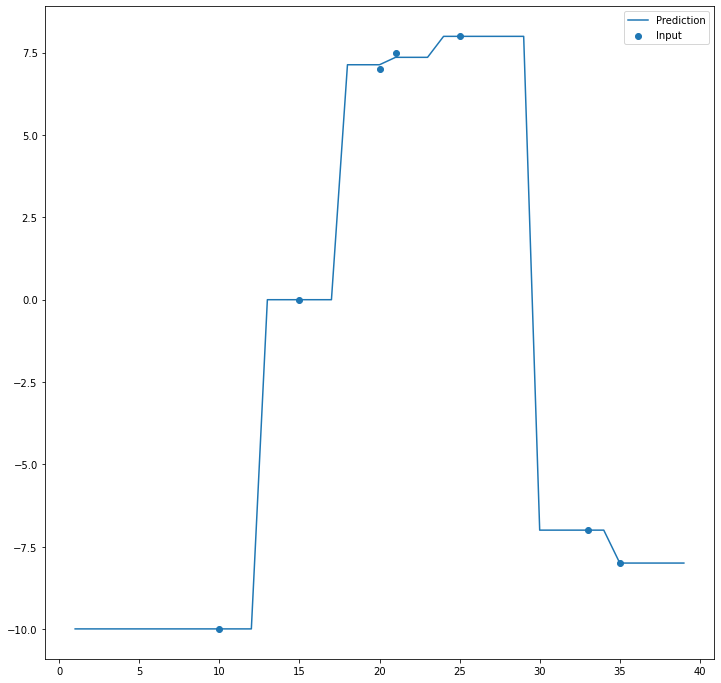

In [487]:
n_trees = 20
xg = XGBoost(n_trees, max_depth=4)
xg.fit(X,Y)


X_ = range(1, 40)
plt.figure(figsize=(12,12))
plt.scatter(X,Y, label='Input')

plt.plot(X_, xg.predict(X_), label=f'Prediction')
plt.legend()
plt.show()

## Checking with Other funcitons

In [312]:
import math
import numpy.random as npr

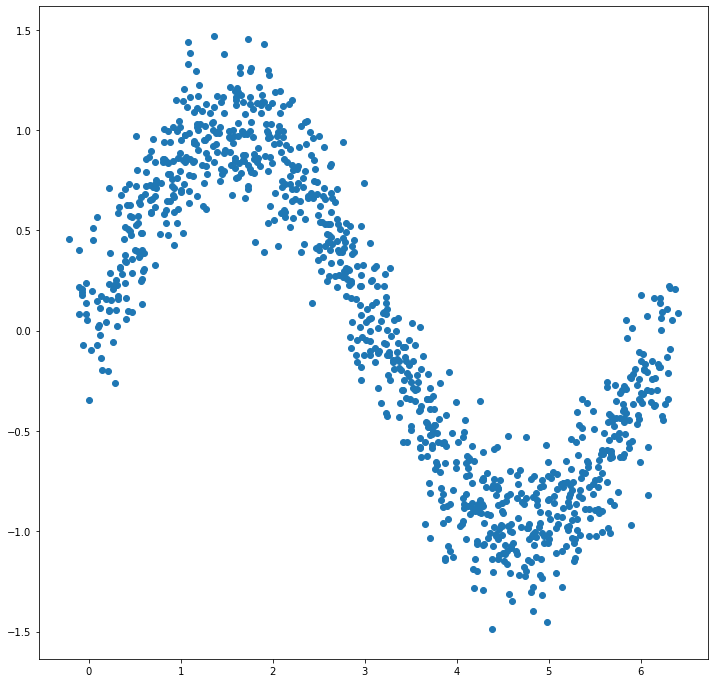

In [478]:
N = 1000
X_clean = [val/N*math.pi*2 for val in range(0, N)]
Y_clean = [math.sin(x) for x in X_clean]
noise_y = list(npr.normal(size=N)*.2)
noise_x = list(npr.normal(size=N)*.1)

X = [x+n for x,n in zip(X_clean, noise_x)]
Y = [y+n for y,n in zip(Y_clean, noise_y)]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)
plt.show()

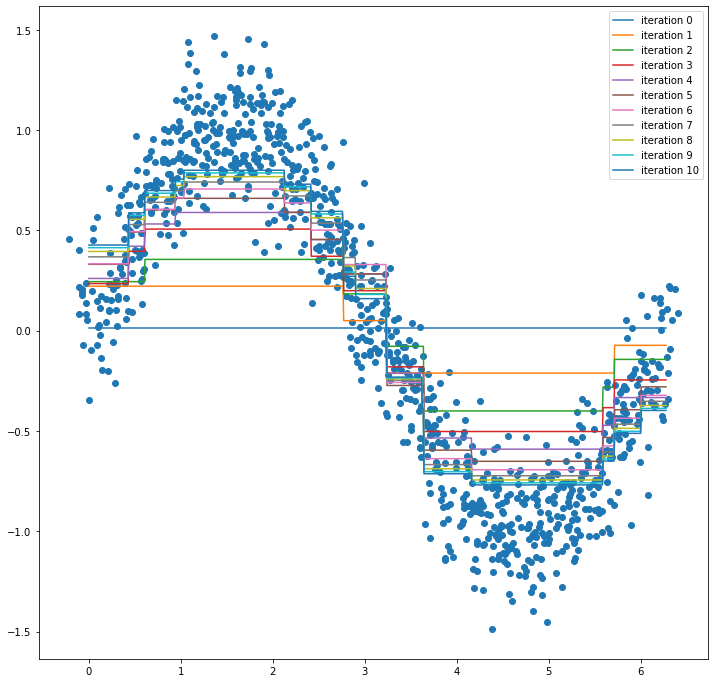

In [480]:
n_trees = 10
tr = XGBoost(n_trees=n_trees, max_depth=2, lambd=1)
tr.fit(X,Y)


plt.figure(figsize=(12,12))
#plt.plot(X_clean, tr.predict(X_clean), 'red')
for i in range(n_trees+1):
  plt.plot(X_clean, tr.predict(X_clean, i), label=f'iteration {i}')
plt.scatter(X, Y)
plt.legend()
plt.show()